In [22]:
### INITIALIZING AND DATA GATHERING ###
import pandas
import numpy
pandas.set_option('display.max_columns',500)
pandas.set_option('display.max_rows',700)
pandas.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
import json
from pandas.io.json import json_normalize
from numpy.random import choice
from collections import Counter
import math


# ------------------ uncomment the section below to refresh time series actuals data ------------------------

#Tiingo: equity and forex info https://api.tiingo.com/documentation/end-of-day
# headers = {
#     'Content-Type': 'application/json'
# }

# with open('tiingo_config.json') as config_file:
#     config_data = json.load(config_file)

# token = config_data['token']

# #Equity data
# start = '2018-01-01'
# end = '2020-12-31'
# agg = 'daily' #daily, weekly, monthly, annually
# responses = pandas.DataFrame(columns = ['date','close','high','low','open','volume','adjClose','adjHigh','adjLow','adjOpen','adjVolume','divCash','splitFactor','name'])
# ticker_list =['LYFT','CCL','MTCH','GRUB','DIS','TSLA','NLY','FNKO','HPE','ACB','KHC','LEVI','PYPL','IAU','GBTC','RSP','BLL','LTC','DDOG','FANG','GE','WWE']

# for ticker in ticker_list:
#     r = requests.get('https://api.tiingo.com/tiingo/daily/'+ticker+'/prices?startDate='+start+'&endDate='+end+'&resampleFreq='+agg+'&token='+token, headers=headers)
#     j = r.json()
#     df = pandas.DataFrame(json_normalize(j))
#     df['name'] = ticker
#     responses = pandas.concat([responses, df], axis=0)

# responses['date'] = pandas.to_datetime(responses['date']).apply(lambda x: x.date())
# responses.to_csv('stock_time_series.csv')

# -----------------------------------------------------------------------------------------------------

################ user inputs required here ###############
trailing_days = 50
symbol = 'DIS'
fcst_start_date = '2020-09-02'
model_start_date = '2018-01-01'
model_end_date = '2020-12-31'
simulations = 10000
##########################################################

data = pandas.read_csv('stock_time_series.csv')
data = data.drop(['Unnamed: 0','close','high','low','volume','open','adjHigh','adjLow','splitFactor'],axis=1)
data['date'] = pandas.to_datetime(data['date'])
data = data.set_index('date')
data['MA5'] = data.groupby('name')['adjClose'].transform(lambda x: x.rolling(5, 1).mean())
data['MA10'] = data.groupby('name')['adjClose'].transform(lambda x: x.rolling(10, 1).mean())
data['Vol5'] = data.groupby('name')['adjVolume'].transform(lambda x: x.rolling(5, 1).mean())
data['Vol10'] = data.groupby('name')['adjVolume'].transform(lambda x: x.rolling(10, 1).mean())
data['past_close_1_day'] = data.groupby('name')['adjClose'].shift(1)
data['past_trailing'] = data.groupby('name')['adjClose'].shift(trailing_days)
data['return_1_day'] = data['adjClose']/data['past_close_1_day']-1
data['return_trailing'] = data['adjClose']/data['past_trailing']-1
names = data['name'].unique().tolist()
all_sims = pandas.DataFrame()
stock = data[numpy.logical_and(data['name']==symbol,numpy.logical_and(data.index<=model_end_date,data.index>=model_start_date))]['return_trailing'].dropna().tolist()
init = data[numpy.logical_and(data['name']==symbol,data.index==fcst_start_date)]['adjClose'].iloc[0]
stock_rounded = [round(i,3)*100 for i in stock]
c = Counter(stock_rounded)
return_combo = [(i, c[i] / len(stock_rounded) * 100.0) for i, count in c.most_common()]
returns = [sublist[0] for sublist in return_combo]
weights = numpy.array([sublist[1] for sublist in return_combo])
weights /= weights.sum()

for i in range(simulations):
    draw = choice(returns,1,p=weights)
    df = pandas.DataFrame(data={'return': draw})
    all_sims = pandas.concat([all_sims,df])
    
all_sims['price_on_'+str(fcst_start_date)] = init
all_sims['price_'+str(trailing_days)+'_days_later'] = all_sims['price_on_'+str(fcst_start_date)]*(1+(all_sims['return']/100))

Price on 2020-09-02: 135.39
Mean percent return: 2%
Standard deviation: 12%
Best percent return simulation: 42%
Worst percent return simulation: -41%
% of simulations that were profitable: 60%


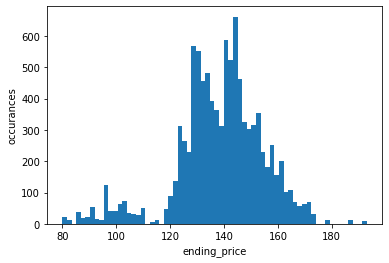

In [23]:
print('Price on '+str(fcst_start_date)+': '+str(all_sims['price_on_'+str(fcst_start_date)].min()))
print('Mean percent return: '+"{:.0f}%".format((all_sims['return']).mean()))
print('Standard deviation: '+"{:.0f}%".format((all_sims['return']).std()))
print('Best percent return simulation: '+"{:.0f}%".format((all_sims['return']).max()))
print('Worst percent return simulation: '+"{:.0f}%".format((all_sims['return']).min()))
print('% of simulations that were profitable: '+"{:.0%}".format(((all_sims['price_'+str(trailing_days)+'_days_later']>all_sims['price_on_'+str(fcst_start_date)]).sum()/simulations)))
plt.hist(all_sims['price_'+str(trailing_days)+'_days_later'],bins='auto')
plt.ylabel('occurances')
plt.xlabel('ending_price')
plt.show()

In [24]:
test_mean = all_sims['price_'+str(trailing_days)+'_days_later'].mean()
test_sigma = all_sims['price_'+str(trailing_days)+'_days_later'].std()
probability_of_upto_num = "{:.0%}".format(st.norm.cdf((140-test_mean)/test_sigma))

print(probability_of_upto_num)

53%
